# Bulk Parameter Explorer — Adjust All Molecules at Once

Use `MoleculeDict.bulk_update_parameters()` to change a shared parameter across all molecules simultaneously. Here a single slider controls the distance to the source, which scales the flux of every molecule.

In [4]:
# Core libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Use the interactive widget backend for matplotlib
%matplotlib widget

# IPython widget libraries
import ipywidgets as widgets
from IPython.display import display, clear_output

# iSLAT data types
from iSLAT.Modules.DataTypes import Molecule, MoleculeDict

# iSLAT standalone plot classes
from iSLAT.Modules.Plotting import (
    BasePlot,
    DEFAULT_THEME,
    LineInspectionPlot,
    PopulationDiagramPlot,
    FullSpectrumPlot,
    MainPlotGrid,
)

print("Imports successful!")
print(f"matplotlib backend: {matplotlib.get_backend()}")

Imports successful!
matplotlib backend: widget


In [5]:
# --- Load observed data and define a molecule factory ---
import pandas as pd

from iSLAT.Modules.FileHandling import example_data_folder_path, hitran_data_folder_path

# Load CI Tau MIRI spectrum (Banzatti+2023b)
data_path = example_data_folder_path / "CITau_MIRI_Banzatti+2023b.csv"
obs = pd.read_csv(data_path)

wave_grid     = obs["wave"].values
observed_flux = obs["flux"].values
observed_err  = obs["err"].values
continuum     = obs["cont"].values

print(f"Loaded: {data_path.name}")
print(f"  {len(wave_grid)} points, {wave_grid.min():.2f}–{wave_grid.max():.2f} μm")

# Paths to HITRAN parameter files
data_dir = hitran_data_folder_path
water_par_file = str(data_dir / "data_Hitran_H2O.par")
co_par_file    = str(data_dir / "data_Hitran_CO.par")
co2_par_file   = str(data_dir / "data_Hitran_CO2.par")

# Wavelength range derived from observed data
wavelength_range = (float(wave_grid.min()), float(wave_grid.max()))

# Default molecule definitions (shared across all sections)
DEFAULT_MOLECULES = {
    "H2O": {"Molecule Name": "H2O", "temp": 850, "n_mol": 1e18, "radius": 0.5, "color": "#0000FF",
             "displaylabel": "$H_2O$", "File Path": water_par_file},
    "CO":  {"Molecule Name": "CO",  "temp": 1000, "n_mol": 1e18, "radius": 0.4, "color": "#FF0000",
             "displaylabel": "CO",  "File Path": co_par_file},
    "CO2": {"Molecule Name": "CO2", "temp": 300,  "n_mol": 1e17, "radius": 0.5, "color": "green",
             "displaylabel": "$CO_2$", "File Path": co2_par_file},
}

def create_mol_dict():
    """
    Create a fresh, independent MoleculeDict with the default molecules.
    """
    md = MoleculeDict(
        global_distance=160,
        global_stellar_rv=0.0,
        global_wavelength_range=wavelength_range,
        global_model_pixel_res=0.0013,
    )
    md.load_molecules(
        molecules_data=[v for v in DEFAULT_MOLECULES.values()],
        initial_molecule_parameters=DEFAULT_MOLECULES,
    )
    md.bulk_update_parameters({"fwhm": 130, "broad": 1})
    return md

# Quick sanity check
_test = create_mol_dict()
print(f"create_mol_dict() -> {list(_test.keys())}")
del _test

Loaded: CITau_MIRI_Banzatti+2023b.csv
  10672 points, 4.90–28.72 μm
Deferring intensity calculations for 3 molecules
create_mol_dict() -> ['H2O', 'CO', 'CO2']


Deferring intensity calculations for 3 molecules
Calculating intensity for H2O: T=850.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for CO: T=1000.0K, N_mol=1.00e+18, dv=1.0
Calculating intensity for CO2: T=300.0K, N_mol=1.00e+17, dv=1.0


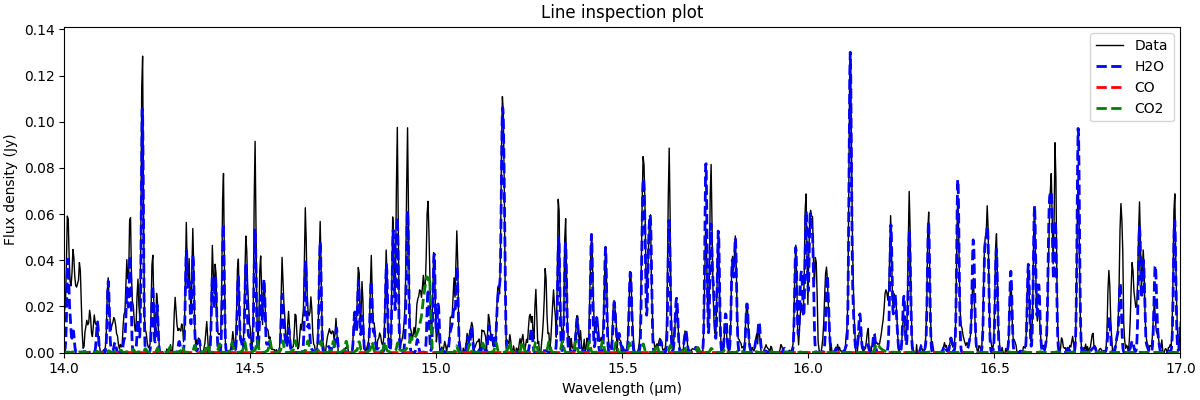

In [6]:
# --- Global distance slider affecting all molecules ---

mol_dict = create_mol_dict()

bulk_lip = LineInspectionPlot(
    wave_data=wave_grid,
    flux_data=observed_flux,
    xmin=14.0,
    xmax=17.0,
    molecules=mol_dict,
    figsize=(12, 4),
)
bulk_lip.generate_plot()

distance_slider = widgets.IntSlider(
    value=int(mol_dict.global_distance),
    min=50, max=500, step=10,
    description='Distance (pc):',
    continuous_update=True,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
)

fwhm_slider = widgets.IntSlider(
    value=130,
    min=10, max=500, step=10,
    description='FWHM (km/s):',
    continuous_update=True,
    style={'description_width': '120px'},
    layout=widgets.Layout(width='500px'),
)

bulk_status = widgets.HTML(value=f"<i>Distance: {mol_dict.global_distance} pc | FWHM: 130 km/s</i>")

def on_bulk_change(change):
    """Update global distance and FWHM for all molecules."""
    mol_dict.global_distance = float(distance_slider.value)
    mol_dict.bulk_update_parameters({'fwhm': float(fwhm_slider.value)})
    bulk_lip.generate_plot()
    bulk_lip.fig.canvas.draw_idle()
    bulk_status.value = (
        f"<i>Distance: {distance_slider.value} pc | "
        f"FWHM: {fwhm_slider.value} km/s</i>"
    )

distance_slider.observe(on_bulk_change, names='value')
fwhm_slider.observe(on_bulk_change, names='value')

display(widgets.VBox([distance_slider, fwhm_slider, bulk_status]))
bulk_lip.show()